In [ ]:
# !chmod 600 /content/kaggle.json
# %env KAGGLE_CONFIG_DIR=/content
# !kaggle datasets download -d aryarishabh/hand-gesture-recognition-dataset
# !unzip -q hand-gesture-recognition-dataset.zip
# !mkdir Dataset
# !mv ./train/train ./Dataset
# !mv ./test/test ./Dataset
# !rmdir ./train
# !rmdir ./test
# !rm ./hand-gesture-recognition-dataset.zip

env: KAGGLE_CONFIG_DIR=/content
 93% 35.0M/37.6M [00:02<00:00, 16.7MB/s]
100% 37.6M/37.6M [00:03<00:00, 13.1MB/s]


In [ ]:
import tensorflow as tf;

import numpy as np;
import matplotlib.pyplot as plt;

In [ ]:
tf.keras.utils.set_random_seed(42);
vgg16 = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3), pooling="max")
# vgg16.summary()

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
bs = 64;
train_ds = tf.keras.utils.image_dataset_from_directory("./Dataset/train/", label_mode="categorical", batch_size=bs, image_size=(50, 50), shuffle=True);
test_ds = tf.keras.utils.image_dataset_from_directory("./Dataset/test/", label_mode="categorical", batch_size=bs, image_size=(50, 50), shuffle=True);

train_ds, test_ds

Found 18000 files belonging to 20 classes.
Found 6000 files belonging to 20 classes.


(<BatchDataset element_spec=(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>)

In [ ]:
def map_func(image, label):
    image = tf.cast(image, tf.uint8);
    image = tf.keras.applications.vgg16.preprocess_input(image);
    return (image, label);
train_ds = train_ds.map(map_func, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False);
test_ds = test_ds.map(map_func, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False);
val_ds = test_ds.take(int(.8*6000//bs))
test_ds = test_ds.skip(int(.8*6000//bs))
train_ds, test_ds

(<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>,
 <SkipDataset element_spec=(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>)

In [ ]:
# sample = train_ds.take(3);
# sample.cardinality()

In [ ]:
# img = next(iter(sample))[0][0];
# plt.imshow(img);

In [ ]:
# features = vgg16.predict(sample);
# features.shape

In [ ]:
x = vgg16.output;
x = tf.keras.layers.Dense(1024, activation="relu")(x);
preds = tf.keras.layers.Dense(20, activation="softmax")(x);

laeeb = tf.keras.models.Model(inputs=vgg16.input, outputs=preds);
# laeeb.summary()

# TRY: replacing this loop with vgg16.trainable=False
for layer in vgg16.layers:
    layer.trainable = False;

In [ ]:
laeeb.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()]);

In [ ]:
history = laeeb.fit(train_ds, validation_data=val_ds, epochs=8);
# history = laeeb.fit(sample, epochs=2);
history.params

Epoch 1/8
282/282 [==============================] - 16s 29ms/step - loss: 0.7354 - binary_accuracy: 0.9813 - val_loss: 0.3987 - val_binary_accuracy: 0.9878
Epoch 2/8
282/282 [==============================] - 8s 27ms/step - loss: 0.3121 - binary_accuracy: 0.9903 - val_loss: 0.3172 - val_binary_accuracy: 0.9899
Epoch 3/8
282/282 [==============================] - 8s 28ms/step - loss: 0.2117 - binary_accuracy: 0.9928 - val_loss: 0.2954 - val_binary_accuracy: 0.9906
Epoch 4/8
282/282 [==============================] - 8s 28ms/step - loss: 0.1800 - binary_accuracy: 0.9937 - val_loss: 0.2986 - val_binary_accuracy: 0.9909
Epoch 5/8
282/282 [==============================] - 8s 28ms/step - loss: 0.1631 - binary_accuracy: 0.9942 - val_loss: 0.3119 - val_binary_accuracy: 0.9904
Epoch 6/8
282/282 [==============================] - 8s 28ms/step - loss: 0.1331 - binary_accuracy: 0.9954 - val_loss: 0.3488 - val_binary_accuracy: 0.9898
Epoch 7/8
282/282 [==============================] - 8s 28ms/st

{'verbose': 1, 'epochs': 8, 'steps': 282}

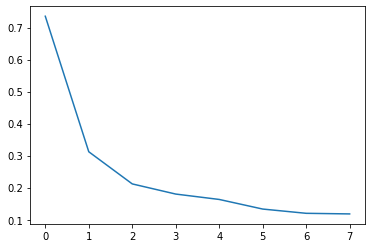

In [ ]:
plt.plot(history.history["loss"]);

In [ ]:
laeeb.evaluate(test_ds)
# laeeb.evaluate(test_ds.take(3))

19/19 [==============================] - 2s 50ms/step - loss: 0.4775 - binary_accuracy: 0.9877


[0.47751301527023315, 0.987666666507721]

In [ ]:
for i, layer in enumerate(vgg16.layers):
  print(i, layer.name);

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_max_pooling2d


In [ ]:
for layer in laeeb.layers[:15]:
  layer.trainable = False;
for layer in laeeb.layers[15:]:
  layer.trainable = True;

laeeb.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()]);

In [ ]:
history = laeeb.fit(train_ds, validation_data=val_ds, epochs=4);
# history = laeeb.fit(sample, epochs=2);
history.params

Epoch 1/4
282/282 [==============================] - 12s 37ms/step - loss: 0.2699 - binary_accuracy: 0.9932 - val_loss: 0.1233 - val_binary_accuracy: 0.9960
Epoch 2/4
282/282 [==============================] - 10s 37ms/step - loss: 0.0360 - binary_accuracy: 0.9988 - val_loss: 0.0993 - val_binary_accuracy: 0.9967
Epoch 3/4
282/282 [==============================] - 11s 37ms/step - loss: 0.0135 - binary_accuracy: 0.9996 - val_loss: 0.0722 - val_binary_accuracy: 0.9975
Epoch 4/4
282/282 [==============================] - 13s 44ms/step - loss: 0.0079 - binary_accuracy: 0.9998 - val_loss: 0.0597 - val_binary_accuracy: 0.9981


{'verbose': 1, 'epochs': 4, 'steps': 282}

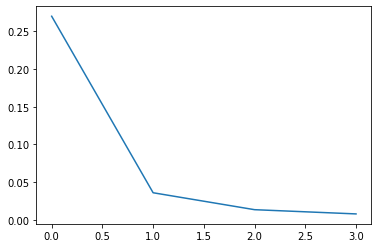

In [ ]:
plt.plot(history.history["loss"]);

In [ ]:
laeeb.evaluate(test_ds);

19/19 [==============================] - 1s 25ms/step - loss: 0.0970 - binary_accuracy: 0.9971
